In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs, PublicPredictor
from src.dbc import utils
from IPython.display import clear_output

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

In [4]:
m_15 = utils.data_preprocessing(xlsx)

df = utils.dimension_reduction(m_15)
m_60 = df.copy()

m_60.head()

m_60_1 = m_60[m_60.index.month == 1].copy()
m_60_1.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2019-01-01 00:00:00,0.033,0.000,0.034,0.037,0.062,0.322,0.240,0.295,0.373,0.243,...,0.534,0.188,0.400,0.318,0.420,0.626,0.484,0.289,0.305,0.652
2019-01-01 01:00:00,0.048,0.000,0.033,0.037,0.063,0.185,0.257,0.397,0.257,0.228,...,0.396,0.434,0.355,0.250,0.465,0.409,0.459,0.336,0.332,0.557
2019-01-01 02:00:00,0.032,0.000,0.039,0.036,0.062,0.175,0.384,0.353,0.123,0.141,...,0.194,0.337,0.379,0.274,0.326,0.307,0.405,0.382,0.311,0.491
2019-01-01 03:00:00,0.033,0.000,0.039,0.037,0.062,0.167,0.276,0.488,0.142,0.159,...,0.286,0.263,0.375,0.264,0.336,0.345,0.298,0.291,0.261,0.511
2019-01-01 04:00:00,0.032,0.001,0.033,0.037,0.063,0.197,0.266,0.278,0.190,0.227,...,0.275,0.245,0.310,0.423,0.360,0.364,0.212,0.347,0.294,0.507


이상패턴 조정 확인 True


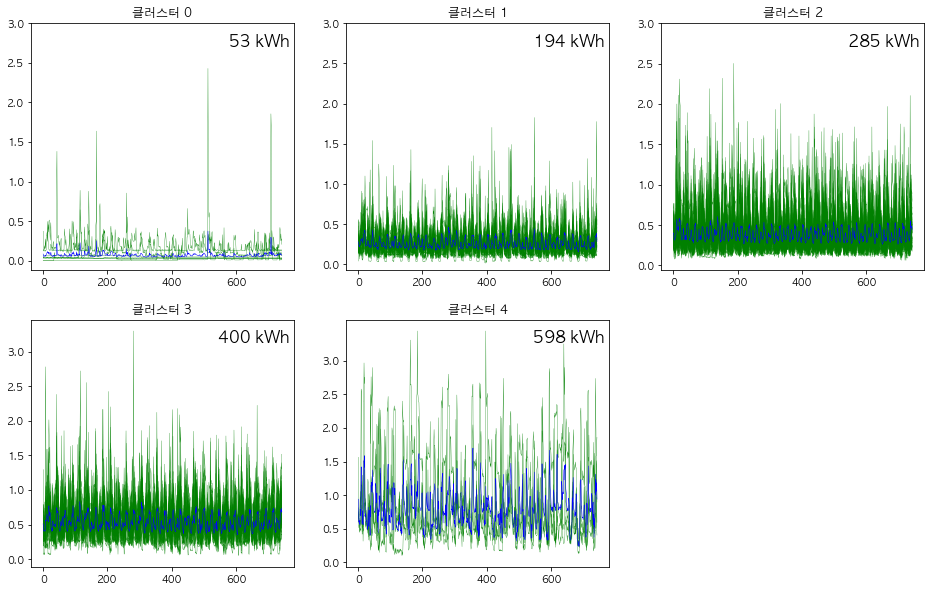

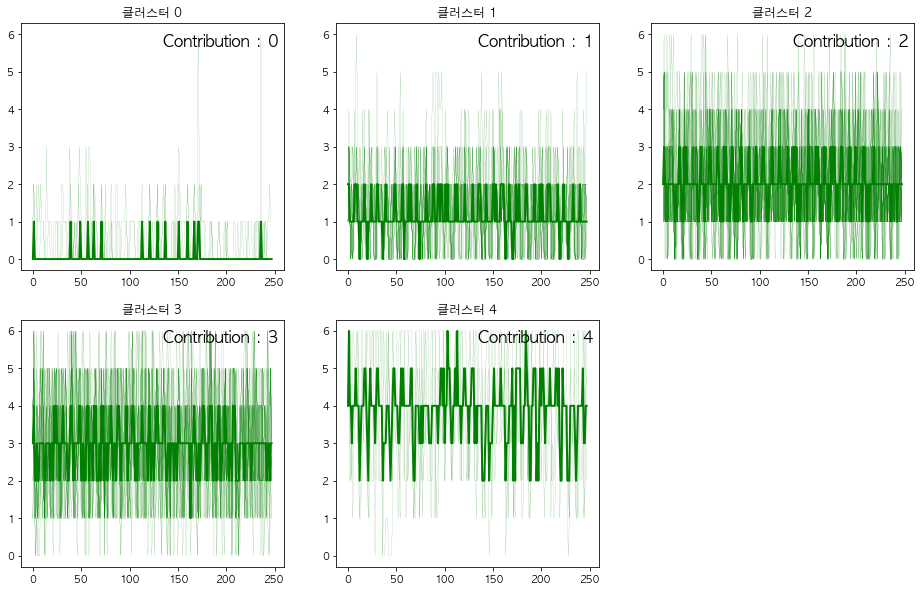

In [101]:
from src import SavingFeedback

sf = SavingFeedback(xlsx, _type="tdkmeans")

sf.select_month(1)
sf.kmeans_run()
sf.adjust_anomaly()

anomaly = sf.check_anomaly()
clear_output(wait=True)
print("이상패턴 조정 확인", len(anomaly) == 0)

sf.kmeans.draw_plot()
sf.kmeans.draw_cont_plot()

### Time Grouping

In [105]:
time_size = 3

sf.time_based_grouping(time_size)

print(sf.kmeans.target_cont_.shape)
print(sf.kmeans.target_cluster_cont_.shape)

sf.feedback()
sf.result()

time_group = sf.new_group.copy()
time_group.head()

print("절약",round(time_group['usage (kWh)'].mean()))

# 의미 있는 피드백이 진행되었다는 거임
sf.recovery()

og_pat = sf.datas.values.T
rec_pat = sf.recoveries
err = (og_pat - rec_pat)

print(og_pat.shape, rec_pat.shape)
print("최소 오차", err[err != 0].min())

(108, 8)
(5, 8)
절약 225
(108, 744) (108, 744)
최소 오차 0.041999999999999996


### Day Grouping

In [106]:
sf.day_based_grouping()
sf.kmeans.set_day_cont_table()

print(sf.kmeans.target_cont_.shape)
print(sf.kmeans.target_cluster_cont_.shape)

sf.feedback()
sf.result()

time_group = sf.new_group.copy()
time_group.head()

print("절약",round(time_group['usage (kWh)'].mean()))

# 의미 있는 피드백이 진행되었다는 거임
sf.recovery()

og_pat = sf.datas.values.T
rec_pat = sf.recoveries
err = (og_pat - rec_pat)

print(og_pat.shape, rec_pat.shape)
print("최소 오차", err[err != 0].min())

(108, 7)
(5, 7)
절약 233
(108, 744) (108, 744)
최소 오차 0.05
